<a href="https://colab.research.google.com/github/marcusflygar1-hash/AH2179_Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# importing the neccesary libraries for the project.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, r2_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Data prepping

In [28]:
tds = pd.read_csv('training_dataset.csv', sep=';')
ev_ds = pd.read_csv('evaluation_dataset.csv',sep=';')
f_ev_ds = pd.read_csv('final_evaluation_dataset.csv', sep=';')


In [29]:
print('\n training dataset')
print(tds.head())
print('\n evaluation dataset------------')
print(ev_ds.head())
print('\n final evaluation dataset --------')
print(f_ev_ds.head())


 training dataset
   DP_ID      PORTAL      Date      Time  Interval_1  Interval_5  Interval_15  \
0    543  E4S 56,780  20210601  04:00:00         240          48           16   
1    539  E4S 56,160  20210601  04:00:00         240          48           16   
2    534  E4S 56,780  20210601  04:00:00         240          48           16   
3    351  E4S 56,490  20210601  04:00:00         240          48           16   
4    353  E4S 57,055  20210601  04:00:00         240          48           16   

   Interval_30  Interval_60  SPEED_MS_AVG  FLOW  
0            8            4         19.34  10.0  
1            8            4         19.64   9.0  
2            8            4         23.36   5.0  
3            8            4         20.14   7.0  
4            8            4         17.70   7.0  

 evaluation dataset------------
   DP_ID      PORTAL      Date      Time  Interval_1  Interval_5  Interval_15  \
0   1254  E4S 55,620  20220101  04:00:00         240          48           16   

In [30]:
print('Training dataset')
print(tds.isna().sum())
print('\n eval dataset')
print(ev_ds.isna().sum())
print('\n final eval dataset')
print(f_ev_ds.isna().sum())

Training dataset
DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            62
dtype: int64

 eval dataset
DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            29
dtype: int64

 final eval dataset
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    0
FLOW            4
dtype: int64


In [31]:
#drop all NaN values.
f_ev_ds_noNAN = f_ev_ds.dropna()
tds_noNAN = tds.dropna()
ev_ds_noNAN = ev_ds.dropna()

In [32]:
print(f'Org dataset amount:{len(tds)}')
print(f'Org dataset amount:{len(ev_ds)}')
print(f'Org dataset amount:{len(f_ev_ds)}')

print(f'Dropped Dataset amount:{len(tds_noNAN)}')
print(f'Dropped Dataset amount:{len(ev_ds_noNAN)}')
print(f'Dropped Dataset amount:{len(f_ev_ds_noNAN)}')

Org dataset amount:1921967
Org dataset amount:803377
Org dataset amount:803501
Dropped Dataset amount:1921905
Dropped Dataset amount:803348
Dropped Dataset amount:803497


In [33]:
#define what is congestion and what is not.
# congestion_flow = tds[tds['FLOW'] < 100]
# congestion_speed = tds[tds['SPEED_MS_AVG'] < 10]

ev_ds_noNAN['datetime'] = pd.to_datetime(ev_ds_noNAN['Date'].astype(str) + ' ' + ev_ds_noNAN['Time'])

ev_ds_offpeak = ev_ds_noNAN[(ev_ds_noNAN['datetime'].dt.time >= pd.to_datetime("04:00:00").time()) &
                            (ev_ds_noNAN['datetime'].dt.time <= pd.to_datetime("06:00:00").time())]
ev_ds_onpeak = ev_ds_noNAN[(ev_ds_noNAN['datetime'].dt.time >= pd.to_datetime("07:30:00").time()) &
                           (ev_ds_noNAN['datetime'].dt.time <= pd.to_datetime("08:30:00").time())]

ev_ds_offpeak = ev_ds_offpeak[(ev_ds_offpeak['FLOW'] > 0) &
                              (ev_ds_offpeak['SPEED_MS_AVG'].between(5, 50))]
ev_ds_onpeak = ev_ds_onpeak[(ev_ds_onpeak['FLOW'] > 0) &
                            (ev_ds_onpeak['SPEED_MS_AVG'].between(5, 50))]


/tmp/ipython-input-176674914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_ds_noNAN['datetime'] = pd.to_datetime(ev_ds_noNAN['Date'].astype(str) + ' ' + ev_ds_noNAN['Time'])


In [34]:
# converting the date and time columns int o just one "datetime" coluinm
tds_noNAN['datetime'] = pd.to_datetime(tds_noNAN['Date'].astype(str) + ' ' + tds_noNAN['Time'])

# filtering the dataset to only include the data within hours 04:00 and 06:00, this to get an accurate description of free flow speed.
tds_offpeak = tds_noNAN[(tds_noNAN['datetime'].dt.time >= pd.to_datetime("04:00:00").time()) &
                (tds_noNAN['datetime'].dt.time <= pd.to_datetime("06:00:00").time())]

tds_onpeak= tds_noNAN[(tds_noNAN['datetime'].dt.time >= pd.to_datetime("07:30:00").time()) &
                  (tds_noNAN['datetime'].dt.time <= pd.to_datetime("08:30:00").time())]
#Ensuring we only get correctly read speeds. E.g Removing any negative speeds and random slow drivers etc
#that do not actually depict the actual free flowspeed e.g people speeding and drinving super slow...
tds_offpeak = tds_offpeak[(tds_offpeak['FLOW'] > 0) &
                        (tds_offpeak['SPEED_MS_AVG'].between(5, 50))]
tds_onpeak = tds_onpeak[(tds_onpeak['FLOW'] > 0) &
                        (tds_onpeak['SPEED_MS_AVG'].between(5, 50))]
# Calculating the free flow speed
# only take the observations in the 85th quantile [m/s]
ffs_ms = (tds_offpeak['SPEED_MS_AVG'].quantile(0.85))
ffs_ms_2 = (tds_onpeak['SPEED_MS_AVG'].quantile(0.85))
# convert to km/h
ffs_kmh = (ffs_ms * 3.6)
ffs_kmh_2 =(ffs_ms_2 * 3.6)
print(f"Free Flow Speed [85th percentile]: \n Free flow speed: {ffs_ms_2 } [m/s] \n Free Flow Speed {ffs_kmh_2} [km/h]")
print(f"Free-flow speed (85th percentile): \n Free flow speed: {ffs_ms} [m/s] \n Free flow speed {ffs_kmh} [km/h]")

/tmp/ipython-input-2205502600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tds_noNAN['datetime'] = pd.to_datetime(tds_noNAN['Date'].astype(str) + ' ' + tds_noNAN['Time'])


Free Flow Speed [85th percentile]: 
 Free flow speed: 22.58 [m/s] 
 Free Flow Speed 81.288 [km/h]
Free-flow speed (85th percentile): 
 Free flow speed: 23.88 [m/s] 
 Free flow speed 85.968 [km/h]


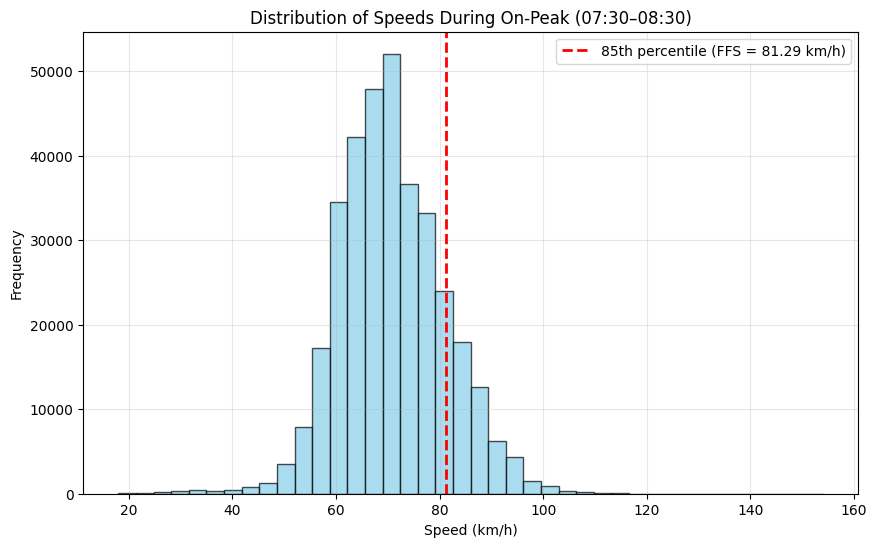

In [35]:
# Calculate FFS (85th percentile)
ffs_ms_2 = tds_onpeak['SPEED_MS_AVG'].quantile(0.85)
ffs_kmh_2 = ffs_ms_2 * 3.6

plt.figure(figsize=(10,6))
plt.hist(tds_onpeak['SPEED_MS_AVG']*3.6, bins=40, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(ffs_kmh_2, color='red', linestyle='--', linewidth=2, label=f'85th percentile (FFS = {ffs_kmh_2:.2f} km/h)')
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Distribution of Speeds During On-Peak (07:30–08:30)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

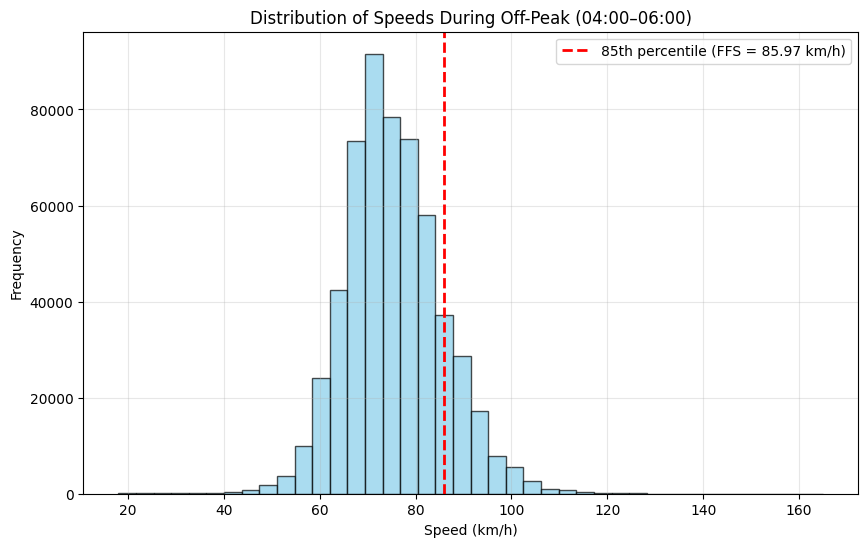

In [36]:
# Calculate FFS (85th percentile)
ffs_ms = tds_offpeak['SPEED_MS_AVG'].quantile(0.85)
ffs_kmh = ffs_ms * 3.6

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(tds_offpeak['SPEED_MS_AVG']*3.6, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(ffs_kmh, color='red', linestyle='--', linewidth=2, label=f'85th percentile (FFS = {ffs_kmh:.2f} km/h)')

plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Distribution of Speeds During Off-Peak (04:00–06:00)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [37]:
# Define Congestion Threshold!
cong_th = ffs_kmh * 0.7 # why 70% of the ffs?
cong_th_2 = ffs_kmh_2 * 0.7

print(f'There is congestion at the avg. speed of: {cong_th} [km/h]')
print(f'There is congestion at the avg. speed of : {cong_th_2} [km/h]')

There is congestion at the avg. speed of: 68.7744 [km/h]
There is congestion at the avg. speed of : 65.0304 [km/h]


In [38]:
# tds_noNAN['pred15'] = tds_noNAN['SPEED_MS_AVG'].shift(-1).rolling(15).mean()
# # congestion if 15 min av speed is less than cong_th (rn 60 km/h)
# tds_noNAN['congestion'] = (tds_noNAN['pred15']*3.6 <= cong_th).astype(int)

tds_noNAN['pred15'] = tds_noNAN['SPEED_MS_AVG'].shift(-1).rolling(15).mean()
tds_noNAN['congestion'] = (tds_noNAN['pred15']*3.6 <= cong_th_2).astype(int)

/tmp/ipython-input-636401689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tds_noNAN['pred15'] = tds_noNAN['SPEED_MS_AVG'].shift(-1).rolling(15).mean()
/tmp/ipython-input-636401689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tds_noNAN['congestion'] = (tds_noNAN['pred15']*3.6 <= cong_th_2).astype(int)


In [39]:
def make_features_targets(df, horizon=15, cong_th_kmh=60):
    """
    Create past-15-minute features and a binary target:
    1 if future average speed (next horizon minutes) <= congestion threshold.
    """

    df = df.copy()

    # --- Future average speed over the next horizon minutes ---
    df[f'future_speed_{horizon}m'] = (
        df['SPEED_MS_AVG'].shift(-horizon).rolling(horizon).mean() * 3.6
    )

    # --- Binary target: congestion (1) vs. free flow (0) ---
    df['future_congestion'] = (df[f'future_speed_{horizon}m'] <= cong_th_kmh).astype(int)

    # --- Feature engineering: past 15-min rolling stats ---
    df['past15_flow_mean']  = df['FLOW'].rolling(15).mean()
    df['past15_flow_std']   = df['FLOW'].rolling(15).std()
    df['past15_flow_min']   = df['FLOW'].rolling(15).min()
    df['past15_flow_max']   = df['FLOW'].rolling(15).max()
    df['past15_flow_slope'] = df['FLOW'] - df['FLOW'].shift(15)

    df['past15_speed_mean']  = df['SPEED_MS_AVG'].rolling(15).mean()
    df['past15_speed_std']   = df['SPEED_MS_AVG'].rolling(15).std()
    df['past15_speed_min']   = df['SPEED_MS_AVG'].rolling(15).min()
    df['past15_speed_max']   = df['SPEED_MS_AVG'].rolling(15).max()
    df['past15_speed_slope'] = df['SPEED_MS_AVG'] - df['SPEED_MS_AVG'].shift(15)

    # --- Cyclical time-of-day features ---
    df["minute_of_day"] = df["datetime"].dt.hour * 60 + df["datetime"].dt.minute
    df["tod_sin"] = np.sin(2 * np.pi * df["minute_of_day"] / 1440)
    df["tod_cos"] = np.cos(2 * np.pi * df["minute_of_day"] / 1440)

    features = [
        'past15_flow_mean','past15_flow_std','past15_flow_min','past15_flow_max','past15_flow_slope',
        'past15_speed_mean','past15_speed_std','past15_speed_min','past15_speed_max','past15_speed_slope',
        'tod_sin','tod_cos'
    ]

    target = 'future_congestion'

    df = df.dropna(subset=features + [target])

    return df, features, target


In [40]:
tds_peak = tds_noNAN[
    (tds_noNAN["datetime"].dt.time >= pd.to_datetime("07:30:00").time()) &
    (tds_noNAN["datetime"].dt.time <= pd.to_datetime("08:30:00").time())
]
tds_fixad, features, target = make_features_targets(tds_peak, horizon=15, cong_th_kmh=cong_th_2)

# 2. Create evaluation data (for 2022)
ev_fixad, _, _ = make_features_targets(ev_ds_noNAN, horizon=15)


In [41]:
#Split into train / test sets
X = tds_fixad[features].values
y = tds_fixad[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
#Scaling the datat.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Test data models

In [53]:
from sklearn.linear_model import LogisticRegression
#perform linear regression model.
lr = LogisticRegression(random_state = 42, max_iter = 1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]


print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=3))

# mae_lr = mean_absolute_error(y_test, y_pred_lr)
# mse_lr = mean_squared_error(y_test, y_pred_lr)
# rmse_lr = np.sqrt(mse_lr)
# r2_lr = r2_score(y_test, y_pred_lr)
# mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

[[45205 12144]
 [ 4384  7794]]
              precision    recall  f1-score   support

           0      0.912     0.788     0.845     57349
           1      0.391     0.640     0.485     12178

    accuracy                          0.762     69527
   macro avg      0.651     0.714     0.665     69527
weighted avg      0.820     0.762     0.782     69527



In [43]:
# #Random forrest model
# random_f = RandomForestRegressor(n_estimators = 100, max_depth = 3, random_state = 42, n_jobs=-1)
# random_f.fit(X_train, y_train)
# y_pred_rf = random_f.predict(X_test)

In [59]:
from xgboost import XGBClassifier
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_scaled, y_train)

# --- Predictions ---
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_prob_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

# --- Evaluate ---
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=3))

[[49385  7964]
 [ 6145  6033]]
              precision    recall  f1-score   support

           0      0.889     0.861     0.875     57349
           1      0.431     0.495     0.461     12178

    accuracy                          0.797     69527
   macro avg      0.660     0.678     0.668     69527
weighted avg      0.809     0.797     0.802     69527



In [45]:
# xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# xgb_model.fit(X_train_scaled, y_train)

# xgb_model.fit(X_train, y_train)
# y_pred_xgb = xgb_model.predict(X_test)
# mae_xgb= mean_absolute_error(y_test, y_pred_xgb)
# mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# rmse_xgb = np.sqrt(mse_xgb)
# r2_xgb = r2_score(y_test, y_pred_xgb)
# mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)


In [46]:
print("Linear Regression")
print(f"Mean Absolute Error (MAE): {mae_lr}")
print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr}")
print(f"R2-score {r2_lr}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lr}")

print("\n")

print("XGBoost")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb}")
print(f"R2-score {r2_xgb}")


Linear Regression
Mean Absolute Error (MAE): 0.20774974944309324
Mean Squared Error (MSE): 0.13325256048920717
Root Mean Squared Error (RMSE): 0.36503775214244233
R2-score 0.07768191429959637
Mean Absolute Percentage Error (MAPE): 288341700984969.06


XGBoost
Mean Absolute Error (MAE): 0.1879599690437317
Mean Squared Error (MSE): 0.12844352424144745
Root Mean Squared Error (RMSE): 0.35839018435421394
Mean Absolute Percentage Error (MAPE): 204400177971200.0
R2-score 0.11096793413162231


In [47]:
# Define congestion threshold (same one you used earlier)
cong_th_2 = ffs_kmh_2 * 0.8  # for example

# From your regression predictions
y_pred_xgb_cong = (y_pred_xgb <= cong_th_2).astype(int)
y_true_cong = (y_test <= cong_th_2).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_true_cong, y_pred_xgb_cong))
print(classification_report(y_true_cong, y_pred_xgb_cong, digits=3))


[[69527]]
              precision    recall  f1-score   support

           1      1.000     1.000     1.000     69527

    accuracy                          1.000     69527
   macro avg      1.000     1.000     1.000     69527
weighted avg      1.000     1.000     1.000     69527



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf_clf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=12,
#     class_weight='balanced',  # handle imbalance
#     random_state=42,
#     n_jobs=-1
# )

# rf_clf.fit(X_train_scaled, y_train)
# y_pred_rf = rf_clf.predict(X_test_scaled)

# print(confusion_matrix(y_test, y_pred_rf))
# print(classification_report(y_test, y_pred_rf, digits=3))

In [61]:
results = []

for name, pred in [
    ("Logistic Regression", y_pred_lr),
    # ("Random Forest", y_pred_rf),
    ("XGBoost", y_pred_xgb)
]:
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred)
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.762279   0.390912  0.640007  0.485366
1              XGBoost  0.797072   0.431021  0.495402  0.460974


# Evaluation data models

In [48]:
ev_peak = ev_ds_noNAN[
    (ev_ds_noNAN["datetime"].dt.time >= pd.to_datetime("07:30:00").time()) &
    (ev_ds_noNAN["datetime"].dt.time <= pd.to_datetime("08:30:00").time())
]
ev_fixad, _, _ = make_features_targets(ev_peak, horizon=15, cong_th_kmh=cong_th_2)


In [49]:
X_eval = ev_fixad[features].values
y_eval = ev_fixad[target].values
X_eval_scaled = scaler.transform(X_eval)

In [60]:
for name, model in [
    ("Logistic Regression", lr),
    # ("Random Forest", rf_clf),
    ("XGBoost", xgb_clf)
]:
    y_pred_eval = model.predict(X_eval_scaled)
    print(f"\n{name} (Evaluation 2022 dataset):")
    print(confusion_matrix(y_eval, y_pred_eval))
    print(classification_report(y_eval, y_pred_eval, digits=3))


Logistic Regression (Evaluation 2022 dataset):
[[111743  21232]
 [  2282  10082]]
              precision    recall  f1-score   support

           0      0.980     0.840     0.905    132975
           1      0.322     0.815     0.462     12364

    accuracy                          0.838    145339
   macro avg      0.651     0.828     0.683    145339
weighted avg      0.924     0.838     0.867    145339


XGBoost (Evaluation 2022 dataset):
[[121552  11423]
 [  4017   8347]]
              precision    recall  f1-score   support

           0      0.968     0.914     0.940    132975
           1      0.422     0.675     0.520     12364

    accuracy                          0.894    145339
   macro avg      0.695     0.795     0.730    145339
weighted avg      0.922     0.894     0.904    145339

